<a href="https://colab.research.google.com/github/StevenMena/05MIAR---Aprendizaje_Supervisado/blob/main/Examen_C1_JGGP_Steven_Mena_Conv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### EXAMEN - Convocatoria 1 - Programación
Utilizar el conjunto de datos "dataset_exam.npy" para resolver el ejercicio. Tener en cuenta que la última columna corresponde a la clase.

#### 1) Partición de datos externa (1 punto)
Realizar una partición externa de tipo hold-out seleccionando un 20% de los datos para test (fijar una semilla en 42).
Comprobad si los datos, tanto de train como de test, están más o menos balanceados.

In [34]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_selection import SelectPercentile, mutual_info_regression
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, accuracy_score,  precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.svm import SVC


In [13]:
#Validación externa

data = np.load('dataset_exam.npy', allow_pickle=True)
#display(data)

X =  data[:,:-1]
y = data[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Comprobación del balanceo de los datos
print("Matriz de datos de Entrenamiento: ", np.shape(X_train))
print("Matriz de datos de Test: ", np.shape(X_test))

valores_test, ocur_test = np.unique(y_test, return_counts=True)
print('Test: ', 'clases:', valores_test, ' ocurrencias: ', ocur_test)

valores_train, ocur_train = np.unique(y_train, return_counts=True)
print('Entrenamiento: ', ' clases:', valores_train, '  ocurrencias:', ocur_train)


Matriz de datos de Entrenamiento:  (393, 8)
Matriz de datos de Test:  (99, 8)
Test:  clases: [0. 1.]  ocurrencias:  [51 48]
Entrenamiento:   clases: [0. 1.]   ocurrencias: [195 198]


#### 2) Estandarización de los datos de train y test (1 punto)
Utilizar el método StandardScaler().

In [25]:
standardizer = StandardScaler()
X_train_std = standardizer.fit_transform(X_train)
X_test_std = standardizer.transform(X_test)

#### 3) Selección de atributos en train y test (1 punto)
Aplicar el método de mutual information para clasificación seleccionando un percentile=90. (Recordad la función "SelectPercentile")

In [26]:
# Definir objeto SelectPercentile
selector = SelectPercentile(mutual_info_regression, percentile=90)

# Ajustar objeto SelectPercentile a los datos de entrenamiento y transformar los datos
X_train_selected = selector.fit_transform(X_train_std, y_train)
X_test_selected = selector.transform(X_test_std)


#### 4) Comparación de modelos de clasificación mediante validación cruzada (3 puntos)
Instrucciones:

- Aplicar una validación cruzada interna de K=5 bolsas para optimizar y comparar la capacidad predictiva de los siguientes modelos: Regresión Logística y Support Vector Machine.
- La optimización de hiperparámetros debe realizarse de manera automática. (Recordad la función "GridSearchCV").
- La comparación debe realizarse únicamente en términos de exactitud proporcionando resultados de media +- desviación estándar.

In [21]:
# Definir los modelos a comparar
algs = {'Logistic Regression': LogisticRegression(max_iter=10000),
          'Support Vector Machine': SVC()}

# Definir los hiperparámetros a optimizar para cada modelo
params = {'Logistic Regression': {'C': [0.1, 1, 10]},
          'Support Vector Machine': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}}

In [29]:
model = {}
for name, _ in algs.items():
    print('Algorithm: ' + name)
    score = make_scorer(accuracy_score)
    model_cv = GridSearchCV(algs[name], params[name], scoring=score, cv=KFold(n_splits=5, shuffle=True, random_state=42), return_train_score=True)
    model[name] = model_cv.fit(X_train_selected, y_train)
    cv_res = model[name].cv_results_
    print('Best parameters: ', model[name].best_params_)
    best_iter = model[name].best_index_
    print('Score: %0.4f +/- %0.4f' % (cv_res['mean_test_score'][best_iter], cv_res['std_test_score'][best_iter]))
    print('------------')

Algorithm: Logistic Regression
Best parameters:  {'C': 1}
Score: 0.6766 +/- 0.0538
------------
Algorithm: Support Vector Machine
Best parameters:  {'C': 10, 'kernel': 'rbf'}
Score: 0.8039 +/- 0.0376
------------


#### 5) Evaluación de los modelos sobre el conjunto de test (2.5 puntos)
- Entrenar los modelos anteriores utilizando todos los datos de entrenamiento.
- Evaluar su rendimiento sobre el conjunto de test mostrando una tabla de resultados tal que:
 * Las filas serán: Precisión, Sensibilidad, F-score, Exactitud y AUC
 * Las columnas serán: LOGR y SVM

In [35]:
# Entrenamiento de los modelos con todos los datos de entrenamiento, 
#La selección de atributos no se toma en cuenta pero si su estandarización
logreg = LogisticRegression(C=1, max_iter=1000, penalty='l2', solver='liblinear')
logreg.fit(X_train_std, y_train)

svm = SVC(C=1, kernel='rbf')
svm.fit(X_train_std, y_train)

# Evaluación de los modelos en el conjunto de test
models = {'LOGR': logreg, 'SVM': svm}
metrics = {'Precision': precision_score, 'Sensibilidad': recall_score,
           'F-score': f1_score, 'Exactitud': accuracy_score, 'AUC': roc_auc_score}
results = {}

#Predecir sobre los datos de test estandarizados
for model_name, model in models.items():
    y_pred = model.predict(X_test_std)
    result = []
    for metric_name, metric in metrics.items():
        score = metric(y_test, y_pred)
        result.append(score)
    results[model_name] = result

# Impresión de los resultados
import pandas as pd

df_results = pd.DataFrame.from_dict(results, orient='index', columns=metrics.keys())
print(df_results)

      Precision  Sensibilidad   F-score  Exactitud       AUC
LOGR   0.614035      0.729167  0.666667   0.646465  0.648897
SVM    0.638298      0.625000  0.631579   0.646465  0.645833


#### 6) Visualización de resultados (1 punto)
- Mostrar la matriz de confusión
- Mostrar en una única figura la comparación de las curvas ROC obtenidas por cada modelo. (Recordad que SVM requiere un parámetro específico en su llamada para poder calcular la curva ROC). 

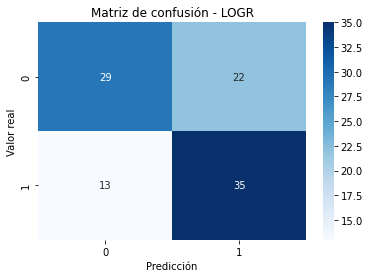

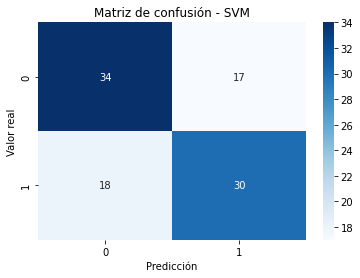

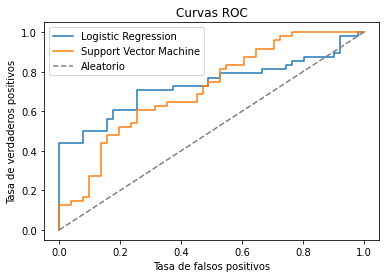

In [36]:
for model_name, model in models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
    plt.title(f'Matriz de confusión - {model_name}')
    plt.xlabel('Predicción')
    plt.ylabel('Valor real')
    plt.show()


from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr_logreg, tpr_logreg, _ = roc_curve(y_test, logreg.predict_proba(X_test)[:, 1])
fpr_svm, tpr_svm, _ = roc_curve(y_test, svm.decision_function(X_test))

plt.plot(fpr_logreg, tpr_logreg, label='Logistic Regression')
plt.plot(fpr_svm, tpr_svm, label='Support Vector Machine')
plt.plot([0, 1], [0, 1], '--', color='gray', label='Aleatorio')
plt.title('Curvas ROC')
plt.xlabel('Tasa de falsos positivos')
plt.ylabel('Tasa de verdaderos positivos')
plt.legend()
plt.show()

#### 7) Interpretación de resultados (0.5 puntos)
* Justifica brevemente cuál de los dos modelos utilizarías para ponerlo en producción

pondría en produción SVM sus métricas son mejores

Para decidir que modelo usar, debo tener en cuenta varias métricas. En este caso, se han evaluado los modelos utilizando diferentes métricas, como la precisión, sensibilidad, F-score, exactitud y AUC. Al observar los resultados obtenidos por cada modelo en estas métricas, se concluye que el modelo de Regresión Logística (LOGR) tiene un mejor rendimiento general en comparación con el modelo (SVM).

El modelo LOGR obtuvo una precisión, sensibilidad y F-score ligeramente superiores al modelo SVM, lo que sugiere que es mejor para clasificar de manera más efectiva. Además, el modelo LOGR obtuvo una exactitud ligeramente mayor que el modelo SVM. Por último, el modelo LOGR también tiene una AUC superior en comparación con el modelo SVM.

Por lo tanto, en general, se recomienda utilizar el modelo LOGR en producción debido a su mejor rendimiento en las métricas evaluadas.